# Image Classification on CIFAR-10 Dataset

In [1]:
# Import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset


In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
import tensorflow_datasets as tfds

# Load CIFAR-10 dataset metadata
cifar10_metadata = tfds.builder('cifar10').info

# Access class names from metadata
class_names = cifar10_metadata.features['label'].names

# Visualize Data

In [4]:
print(f"Training samples: {len(train_images)}")
print(f"Shape of training images: {train_images.shape}")
print(f"Test samples: {len(test_images)}")
print(f"Shape of test images: {test_images.shape}")

Training samples: 50000
Shape of training images: (50000, 32, 32, 3)
Test samples: 10000
Shape of test images: (10000, 32, 32, 3)


In [5]:
# Class names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



    Image shape: (32, 32, 3)
    Image dtype: uint8
    Target class from CIFAR-10 (tensor form): 6
    Class name (str form): frog
    


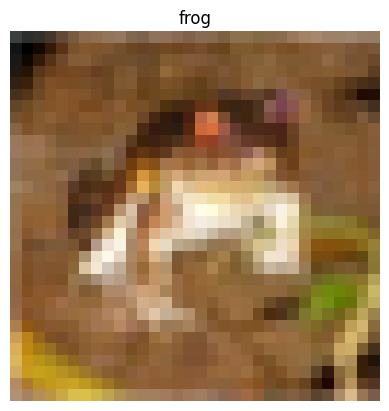


    Image shape: (32, 32, 3)
    Image dtype: uint8
    Target class from CIFAR-10 (tensor form): 9
    Class name (str form): truck
    


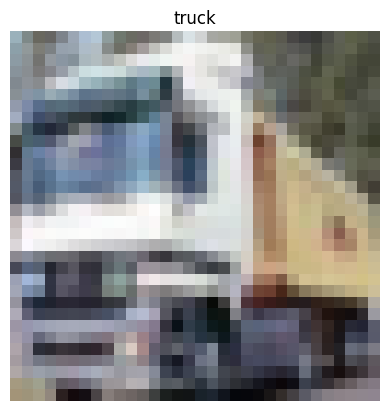


    Image shape: (32, 32, 3)
    Image dtype: uint8
    Target class from CIFAR-10 (tensor form): 9
    Class name (str form): truck
    


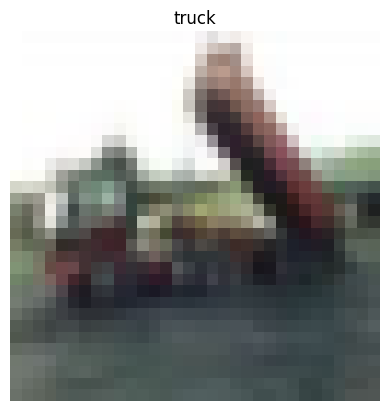


    Image shape: (32, 32, 3)
    Image dtype: uint8
    Target class from CIFAR-10 (tensor form): 4
    Class name (str form): deer
    


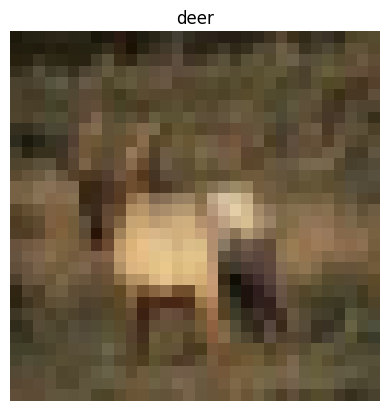


    Image shape: (32, 32, 3)
    Image dtype: uint8
    Target class from CIFAR-10 (tensor form): 1
    Class name (str form): automobile
    


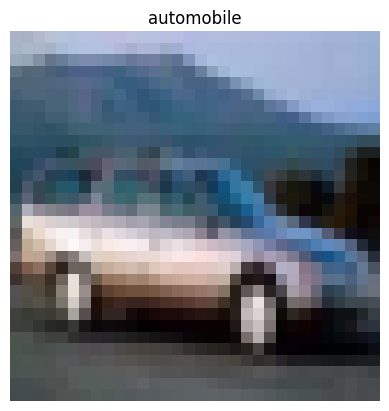

In [6]:
for i in range(5):
    image = train_images[i]
    label = train_labels[i][0]

    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from CIFAR-10 (tensor form): {label}
    Class name (str form): {class_names[label]}
    """)

    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')
    plt.show()

# Preprocess Data

In [7]:
# Set pixel values between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [9]:
# Generate a random permutation of indices
permutation = np.random.permutation(len(train_images))

# Shuffle train_images and train_labels using the same permutation
train_images_shuffled = train_images[permutation]
train_labels_shuffled = train_labels[permutation]

In [10]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding
train_labels_shuffled = to_categorical(train_labels_shuffled, num_classes=10).astype(int)
test_labels = to_categorical(test_labels, num_classes=10).astype(int)

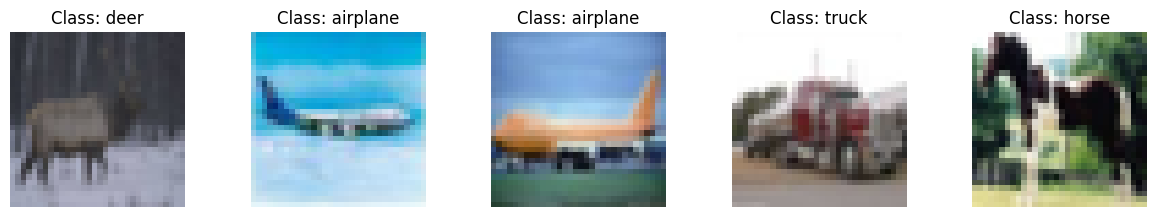

In [13]:
# Show processed images
plt.figure(figsize=(15, 5))
for i in range(5):
    image = train_images_shuffled[i]
    label = np.argmax(train_labels_shuffled[i])
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis('off')
plt.show()

# Image Augmentation

In [14]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # Geometric augmentations
    width_shift_range=0.2,  # Adjust range for more horizontal shifts
    height_shift_range=0.2,  # Adjust range for more vertical shifts
    rotation_range=20,  # Rotate images by a random angle
)

train_generator = data_generator.flow(train_images_shuffled, train_labels_shuffled, 32)

# CNN Model

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=3,
                                        verbose=1,
                                        restore_best_weights=True)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model():
    inputs = tf.keras.Input(shape=(32, 32, 3))

    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Create the model
cnn_model = create_cnn_model()

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Note: from_logits=False when using softmax
                  metrics=['accuracy'])

# Print model summary
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0     

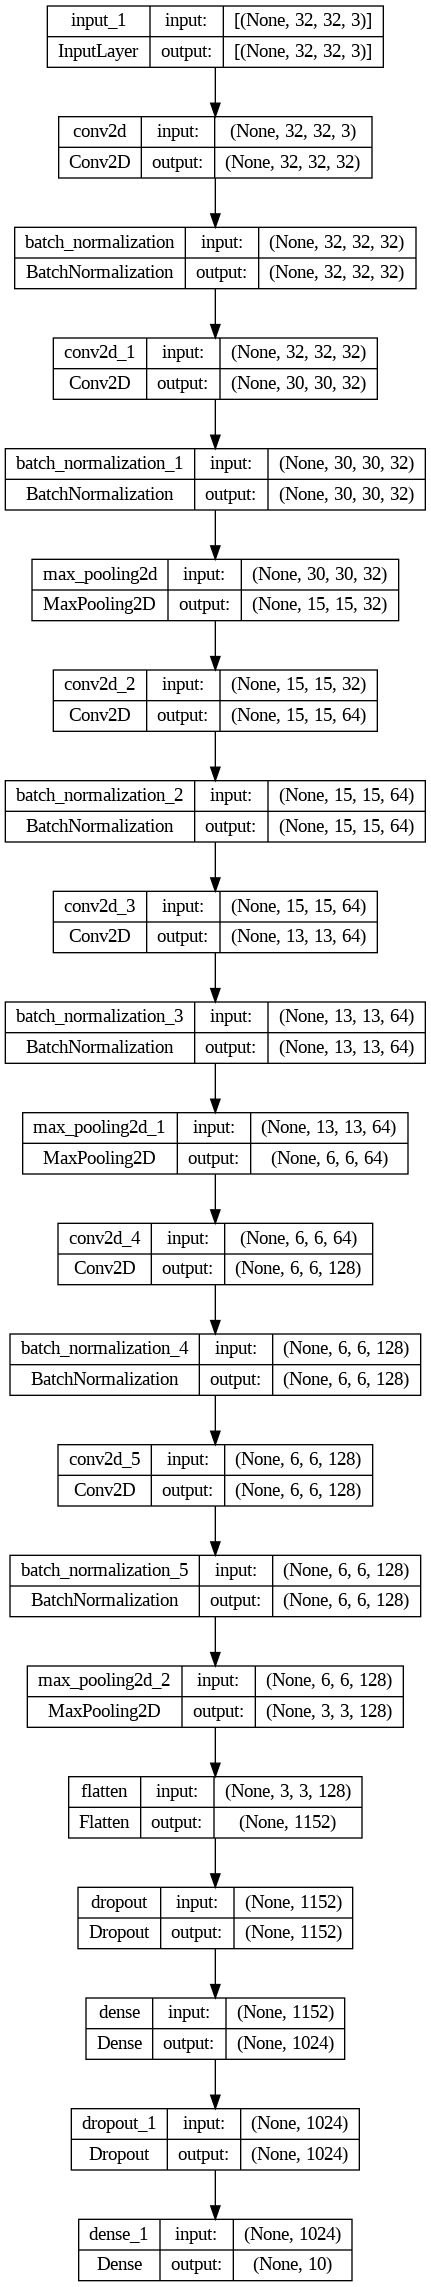

In [17]:
from tensorflow.keras.utils import plot_model

# Create a PNG of the model architecture
plot_model(cnn_model, to_file="model.png", show_shapes=True)

In [18]:
# Train the model
history = cnn_model.fit(train_generator,
                        batch_size=32,
                        epochs=40,
                        validation_data=(test_images, test_labels),
                        callbacks= [checkpoint_callback, early_stopping_callback])

Epoch 1/40
1563/1563 [==============================] - ETA: 0s - loss: 1.6639 - accuracy: 0.4066
Epoch 1: val_loss improved from inf to 1.93364, saving model to model_checkpoint.h5
1563/1563 [==============================] - 48s 25ms/step - loss: 1.6639 - accuracy: 0.4066 - val_loss: 1.9336 - val_accuracy: 0.4246
Epoch 2/40
   1/1563 [..............................] - ETA: 56s - loss: 1.8191 - accuracy: 0.3750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - ETA: 0s - loss: 1.2707 - accuracy: 0.5489
Epoch 2: val_loss improved from 1.93364 to 1.19259, saving model to model_checkpoint.h5
1563/1563 [==============================] - 39s 25ms/step - loss: 1.2707 - accuracy: 0.5489 - val_loss: 1.1926 - val_accuracy: 0.5963
Epoch 3/40
1562/1563 [============================>.] - ETA: 0s - loss: 1.0971 - accuracy: 0.6158
Epoch 3: val_loss improved from 1.19259 to 0.93253, saving model to model_checkpoint.h5
1563/1563 [==============================] - 39s 25ms/step - loss: 1.0971 - accuracy: 0.6158 - val_loss: 0.9325 - val_accuracy: 0.6784
Epoch 4/40
1562/1563 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.6556
Epoch 4: val_loss did not improve from 0.93253
1563/1563 [==============================] - 38s 24ms/step - loss: 0.9870 - accuracy: 0.6556 - val_loss: 0.9847 - val_accuracy: 0.6835
Epoch 5/40
1562/1563 [============================>.] - ETA: 0s - loss: 0.9068 - accuracy

# Evaluate CNN Model

In [27]:
# Load best model
best_model = tf.keras.models.load_model("model_checkpoint.h5")
# Evaluate best_model
loss, accuracy = best_model.evaluate(test_images, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

history = cnn_model.history.history

313/313 [==============================] - 2s 5ms/step - loss: 0.5179 - accuracy: 0.8323
Test Loss: 0.5178560018539429
Test Accuracy: 0.8323000073432922


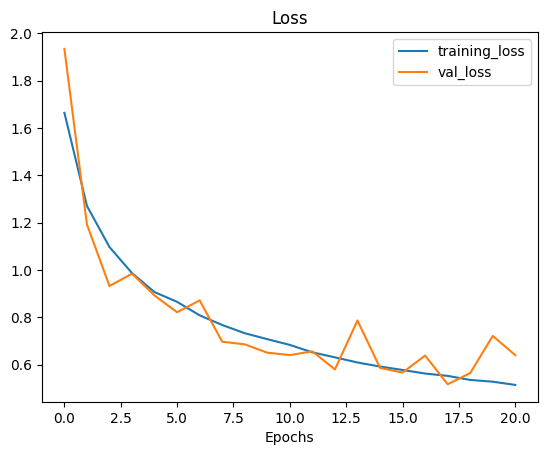

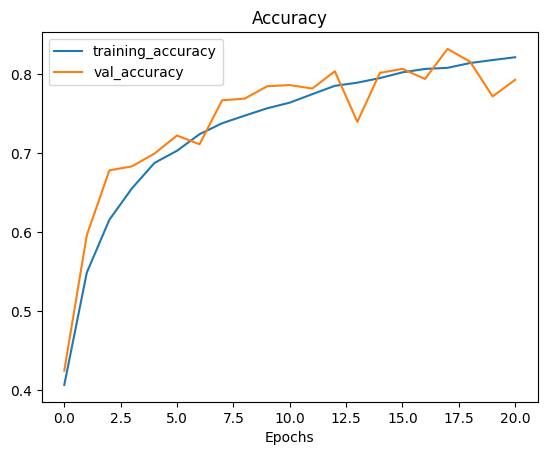

In [31]:
# Plot accuracy and loss
loss = history['loss']
val_loss = history['val_loss']

accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs = range(len(history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();